# Using Prompts to Generate Pictures and Words

1.   List item
2.   List item

The structure of the Assignment is as follows:

1. **Generating images with [Stable Diffusion 1](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0) using text prompts**  

   Here we will explore how we can use text to instruct a model to generate an image.  We'll see how well the model can follow our instructions by asking it to produce specific numbers of objects.  We'll then use a different model to see if the numbers of objects produced is correct.

2. **Examining the capabilities of Mistral**  
   We will then use a recent large language model -- [Mistral 7B](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3) from Mistral -- to illustrate the benefits of an increase in the number of parameters and how it affects the performance of the model.  This model doubles the number or parameters but has also undergone a better pre-training and post-training regime and we would expect that to be reflected in the performance of the model and its ability to follow instructions.



## 1: Multimodality with Image Generation & Captioning
In this notebook we will continue to work with PyTorch and Hugging Face to get more experience with its abstract classes as well as some new models. We will look at the simple task of image generation and use a number of tools to see how we could programatically evaluate the accuracy of the image generation process.

1. **Image Generation**  
   Here we will explore how the stable diffusion model generates images conditioned on a text prompt.

2. **Image Classification**
   Here we will use CLIP to evaluate captions that describe our images to see which labels most accurately describes our generated images.

3. **Image Evaluation**
   We will also use a visual question answering system to ask questions about our generated image.  In our prompt we asked for certain items in the image.  In the question answering system we can ask if those items are present in the image.

**Models we'll use**

**Stable Diffusion** - generate image from prompt

**CLIP** - compare "text" labels with image

**VQA** - answer questions about image


In [ ]:
#mount Google Drive
import os
from google.colab import drive
drive.mount('/content/drive')

# Define your directory
output_folder = "/content/drive/MyDrive/Berkeley MIDS/TestNotebooks/"

# Ensure the output directory exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

Mounted at /content/drive


In [ ]:
!pip install diffusers --upgrade --quiet

In [ ]:
!pip install -q -U transformers
!pip install -q -U bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.7 MB/s eta 0:00:00


In [ ]:
!pip install -q -U invisible_watermark safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00


In [ ]:
#You can generate multiple images but not if you are using
# the T4 GPU.  This assignment is designed to run with a single image

from PIL import Image
from pprint import pprint


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

### Stable Diffusion - Generate Images with one object

We're going to generate an image using stable diffusion ([Model Card](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)). You will specify a prompt that names one object.  Be sure to specify that you want just one. I used ``"portrait of a dog in a chair"``.  How can we programatically tell if the generated image follows our prompt?  We can use some other tools that can examine the photo and tell if it's contents are what we asked for or if the generator fell short. First, you need to load the model and then generate and image.




In [ ]:
from diffusers import DiffusionPipeline
import torch

sd_pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
sd_pipe.to("cuda")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.fp16.saf(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.34.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
### YOUR CODE/PROMPT HERE

#prompt = "a woman wearing a Chanel suit with Chanel pearl necklace"
prompt = "an Indian bride wearing Kundan jewelry with red lehenga"
### END YOUR CODE/PROMPT
images = sd_pipe(prompt=prompt).images[0]

NameError: name 'sd_pipe' is not defined

**QUESTION:**

1.a. What is the enhanced prompt you created to generate the image with the single object? Enter the prompt as a triple quote string in the cell below.

In [ ]:
### Q1-a Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"'an Indian bride wearing Kundan jewelry with red lehenga'"
### END YOUR ANSWER

"'an Indian bride wearing Kundan jewelry with red lehenga'"

Now save the image in your google drive so that when you find one you like you can re-use it in subsequent steps.  We may ask you to show us your `test_single.png` image if it isn't visible in your notebook.

In [ ]:
filename = output_folder + "/test_single.png"
images.save(filename)

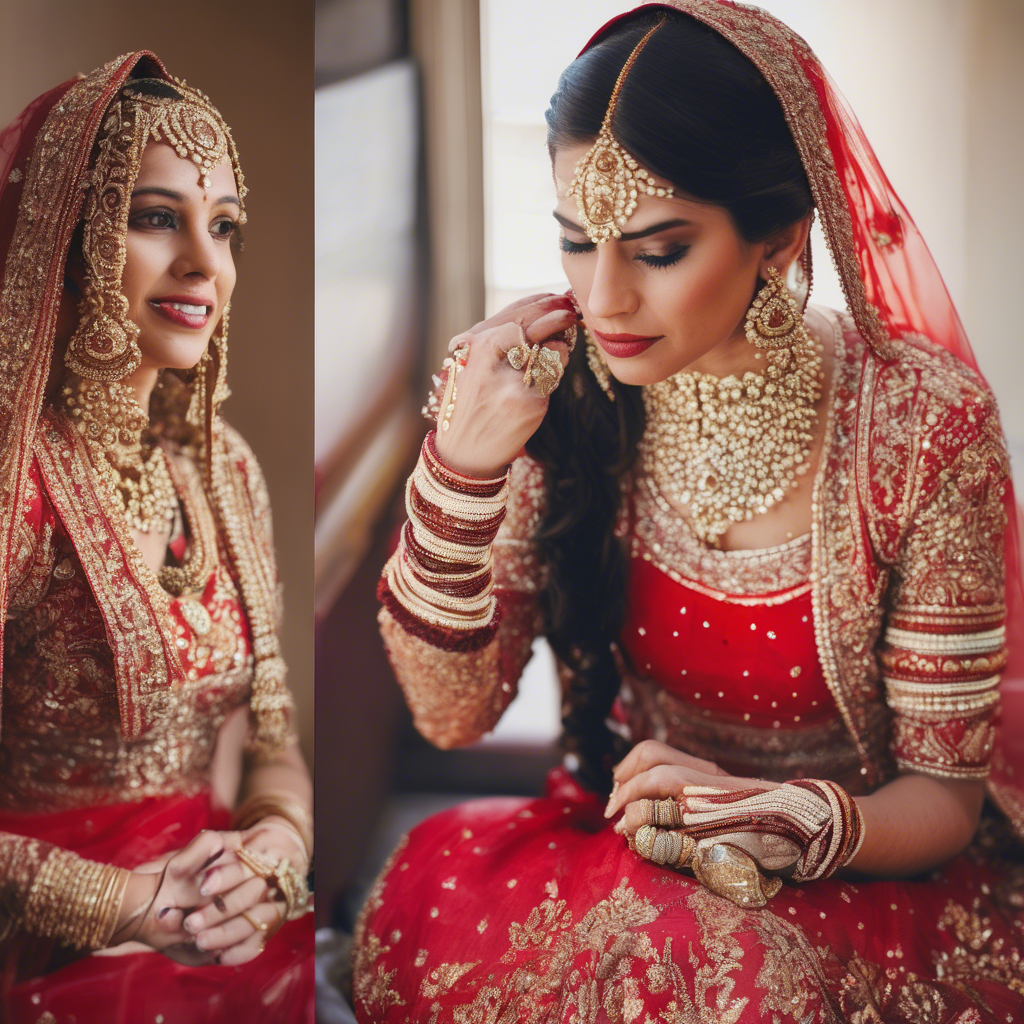

In [ ]:
images

### CLIP - evaluate image with one object

Now we'll use the CLIP model ([Model Card](https://huggingface.co/openai/clip-vit-base-patch32)) to see if our image resembles the object in the prompt.  You'll need to edit the list of captions below.  One label in the list should be the object you requested in the prompt.  Other labels can be similiar objects and one should be orthogonal (very different from your chosen object).  Your labels should each be one or two words long (e.g. cat, dog, blue whale). This is similar to building a classifier that "recognizes" images by predicting one of many possible labels. You should have at least 4 labels.




In [ ]:
!pip install -q Pillow

In [ ]:
import io
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

In [ ]:
%%capture
cl_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
cl_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
from PIL import Image
img_url = '/content/drive/MyDrive/Berkeley MIDS/TestNotebooks/test_single.png'
raw_image = Image.open(img_url, mode='r')

You can apply your four labels here.

In [ ]:
### YOUR CODE HERE

captions = ["Indian bride",
            "red lehenga",
            "kundan set",
            "airplane"]


### END YOUR CODE

inputs = cl_processor(
        text=captions, images=raw_image, return_tensors="pt", padding=True
)

outputs = cl_model(**inputs)
logits_per_image = outputs.logits_per_image            # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)                # we can take the softmax to get the label probabilities


print()
for i, caption in enumerate(captions):
   print('%40s - %.4f' % (caption, probs[0, i]))
print()
print()


                            Indian bride - 0.4184
                             red lehenga - 0.5802
                              kundan set - 0.0014
                                airplane - 0.0000




**QUESTION:**

1.b. What are all of the 1 or 2 word labels you gave to evaluate the generated image? Please list them in a quoted string e.g. "label, label, label, label" in the cell below.


In [ ]:
### Q1-b Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"Indian bride", "red lehenga", "kundan set", "airplane"
### END YOUR ANSWER

('Indian bride', 'red lehenga', 'kundan set', 'airplane')


**QUESTION:**

1.c. What is the correct 1 or 2 word label and the score assigned to it by the CLIP model? Denote this as "(label, number)" in the cell below.




In [ ]:
### Q1-c Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"(Indian bride, 0.4184), (red lehenga - 0.5802), (kundan set - 0.0014), (airplane - 0.0000)"
### END YOUR ANSWER

'(Indian bride, 0.4184), (red lehenga - 0.5802), (kundan set - 0.0014), (airplane - 0.0000)'


Great.  We know the CLIP model can handle more description of the content of the image.  Let's see how well that works.  Instead of your 1 or 2 word labels, create more descriptive captions of roughly 5 to 10 words each.  As with your labels, one caption in your list should describe the object you requested in the prompt. Other captions can be similiar objects and one should be orthogonal (very different from your chosen object).  You must have 4 captions for this question.

In [ ]:
### YOUR CODE HERE

captions = ["An Indian bride in a red lehenga with kundan jewelry",
            "A woman wearing a traditional red lehenga",
            "A bride dressed in Indian wedding attire",
            "A large commercial airplane flying in the sky"]


### END YOUR CODE

inputs = cl_processor(
        text=captions, images=raw_image, return_tensors="pt", padding=True
)

outputs = cl_model(**inputs)
logits_per_image = outputs.logits_per_image            # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)                # we can take the softmax to get the label probabilities


print()
for i, caption in enumerate(captions):
   print('%40s - %.4f' % (caption, probs[0, i]))
print()
print()


An Indian bride in a red lehenga with kundan jewelry - 0.9256
A woman wearing a traditional red lehenga - 0.0630
A bride dressed in Indian wedding attire - 0.0115
A large commercial airplane flying in the sky - 0.0000




**QUESTION:**

1.d. What are the four 5 to 10 word captions you gave to evaluate the image? Enter your multiword captions as a single string "caption one, caption two, caption three, caption four"

In [ ]:
### Q1-d Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"'An Indian bride in a red lehenga with kundan jewelry', 'A woman wearing a traditional red lehenga', 'A bride dressed in Indian wedding attire', 'A large commercial airplane flying in the sky'"
### END YOUR ANSWER

"'An Indian bride in a red lehenga with kundan jewelry', 'A woman wearing a traditional red lehenga', 'A bride dressed in Indian wedding attire', 'A large commercial airplane flying in the sky'"

**QUESTION:**

1.e. What is the correct 5 or 10 word caption and the score assigned to it by the CLIP model?  Denote this as "(caption, number)" in the cell below.



In [ ]:
### Q1-e Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"(An Indian bride in a red lehenga with kundan jewelry, 0.9256), (A woman wearing a traditional red lehenga - 0.0630), (A bride dressed in Indian wedding attire - 0.0115), (A large commercial airplane flying in the sky - 0.0000)"
### END YOUR ANSWER

'(An Indian bride in a red lehenga with kundan jewelry, 0.9256), (A woman wearing a traditional red lehenga - 0.0630), (A bride dressed in Indian wedding attire - 0.0115), (A large commercial airplane flying in the sky - 0.0000)'

### Stable Diffusion -  Object Counts

We're going to generate another image using stable diffusion.  For this new image you will specify a prompt with 3 of the same object *(Type 1)*, 2 of a different kind of object *(Type 2)* "in the background", and two other different individual objects *(Type 3)* and *(Type 4)* in the scene.  For example `3 cats in the garden with 2 snakes in the background with a flowering tree and a rose bush`. Make up your own prompt with your own set of type 1, type 2, type 3, and type 4 objects.

How can we programatically tell if the generated image follows our prompt?  We can use some other tools that can examine the photo and tell if it's contents are what we asked for or if the generator fell short.

Note that each time you run this cell you generate a new image. You may want to try several images before you select one for future processing.



In [ ]:
#Your prompt here

### YOUR CODE/PROMPT HERE

prompt = "Three women wearing Chanel necklaces with Chanel bags in the background with champagne glasses and cake"

### END YOUR CODE/PROMPT
images = sd_pipe(prompt=prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

**QUESTION:**

1.f. What is the prompt you gave to generate your image with the four different types of objects by following our instructions?  Enter the prompt as a triple quoted string in the cell below.

In [ ]:
### Q1-f Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"'Three women wearing Chanel necklaces with Chanel bags in the background with champagne glasses and cake'"
### END YOUR ANSWER

"'Three women wearing Chanel necklaces with Chanel bags in the background with champagne glasses and cake'"

Now make sure you save the image you generate and want to work with as `test_counts.png`.  You will need to show us the image if it isn't visible in your notebook.

In [ ]:

filename = output_folder + "/test_counts.png"
images.save(filename)

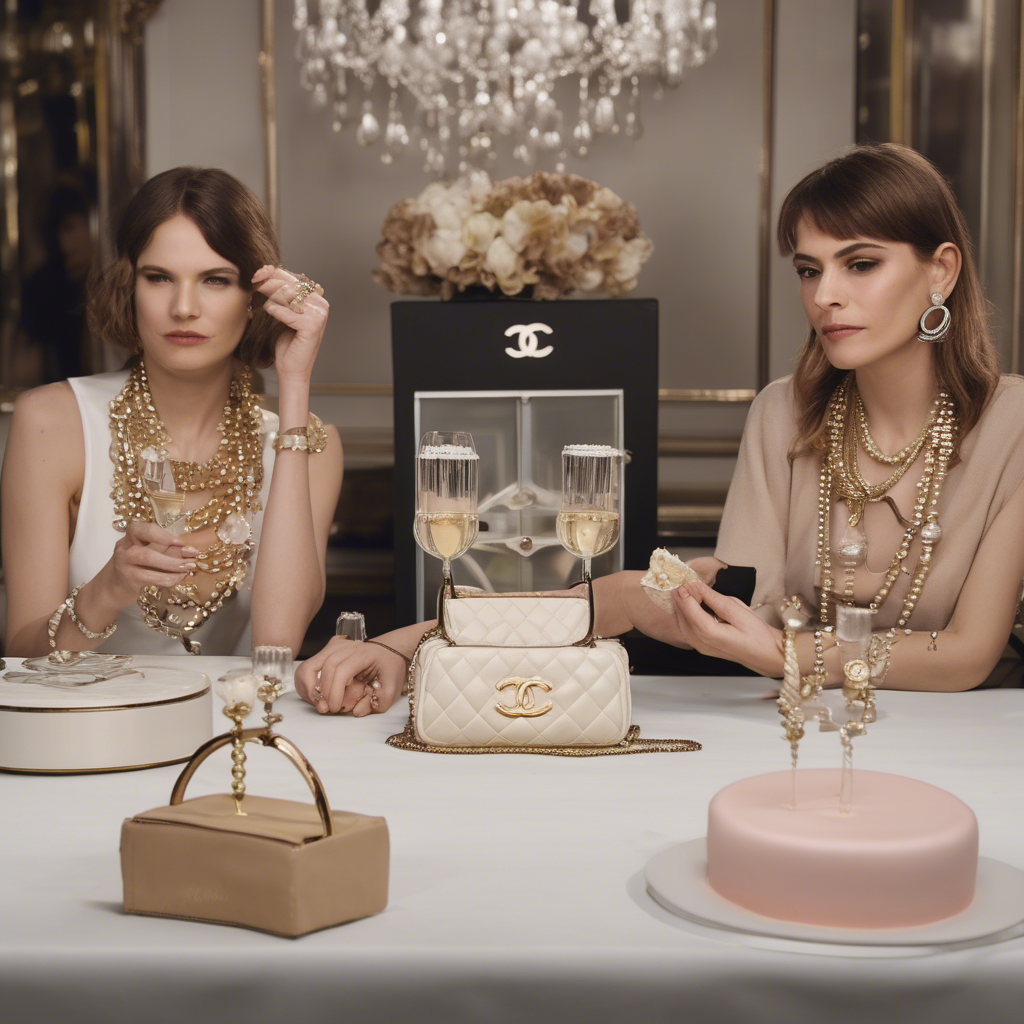

In [ ]:
images

In [ ]:
from PIL import Image
img_url = '/content/drive/MyDrive/Berkeley MIDS/TestNotebooks/test_counts.png'
raw_image = Image.open(img_url, mode='r')

### BLIP for Visual Question Answering

How can we measure how well our stable diffusion model is generating images?  We can look at our one image and assess, but what if we want to test at scale?  To do that we need some kind of automation.  We can leverage other models ot assist. There's a variation of BLIP ([Model Card](https://huggingface.co/Salesforce/blip-vqa-base)) that has been designed to answer questions about the contents of an image.  We'll use that functionality to ask questions to see if the generated image corresponds to the prompt we provided.













In [ ]:
import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", torch_dtype=torch.float16).to("cuda")


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

**QUESTION:**

1.g. How many <type 1> objects does the VQA say are present in your generated image?

In [ ]:
#question = "how many <name of your type 1 objects> are in the picture?"
### YOUR CODE HERE
question = "how many women wearing Chanel necklaces are in the picture?"

### END YOUR CODE


inputs = processor(raw_image, question, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs, max_new_tokens=100)
print(processor.decode(out[0], skip_special_tokens=True))

two


In [ ]:
### Q1-g Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"two"
### END YOUR ANSWER

'two'

**QUESTION:**

1.h. How many <type 2> objects does the VQA say are present in your generated image?

In [ ]:
### YOUR CODE HERE
question = "how many Chanel bags are in the picture?"

### END YOUR CODE


inputs = processor(raw_image, question, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs, max_new_tokens=100)
print(processor.decode(out[0], skip_special_tokens=True))

one


In [ ]:
### Q1-h Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"one"
### END YOUR ANSWER

'one'

**QUESTION:**

1.i. How many <type 2> objects does the VQA say are present in the background of your generated image?

In [ ]:
### YOUR CODE HERE

question = "how many Chanel bags are in the background of the picture?"
### END YOUR CODE


inputs = processor(raw_image, question, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs, max_new_tokens=100)
print(processor.decode(out[0], skip_special_tokens=True))

two


In [ ]:
### Q1-i Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"two"
### END YOUR ANSWER

'two'

**QUESTION:**

1.j. How many <type 3> objects does the VQA say are present in your generated image?

In [ ]:
### YOUR CODE HERE
question = "how many champagne glasses are in the picture?"

### END YOUR CODE


inputs = processor(raw_image, question, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs, max_new_tokens=100)
print(processor.decode(out[0], skip_special_tokens=True))

two


In [ ]:
### Q1-j Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"two"
### END YOUR ANSWER

'two'

**QUESTION:**

1.k. How many <type 4> objects does the VQA say are present in your generated image?

In [ ]:
### YOUR CODE HERE

question = "how many cakes are in the picture?"
### END YOUR CODE


inputs = processor(raw_image, question, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs, max_new_tokens=100)
print(processor.decode(out[0], skip_special_tokens=True))

two


In [ ]:
### Q1-k Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"two"
### END YOUR ANSWER

'two'

**QUESTION: 1.l**

How well does the BLIP VQA system do at accurately counting the number of objects in the image you generated?
- a. It is perfect
- b. It works pretty well but needs improvement
- c. It sees things I don't see
- d. It is less than 50% accurate

Enter the letter of your answer below.

In [ ]:
### Q1-l Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"b"
### END YOUR ANSWER

## 2: Prompt Engineering

In this fourth assignment we will continue to work with PyTorch and Hugging Face to get more experience. We will work with the [Mistral 7B instruction fine tuned model](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2) to practice creating effective prompts.

<a id = 'returnToTop'></a>

The structure of the assignment is as follows:

1. [**Synthetic Data Generation**](#synth-gen)  

   Here we will explore how to generate synthetic review data.


2. [**Synthetic Data Evaluation**](#synth-eval)

   Let's evaluate the synthetic data we just generated and see how accurate it is.



3. [**JSON Record Generation**](#synth-json)

   Let's have the model generate some structured JSON records that incorporate our reviews as well as some other data we specify.



4. [**Chain of Thought Generation**](#cot-gen)

   Let's create a prompt to reason through a set of arithmetic problems and see if it can give the correct answer and "show its work."



5. [**Prompt Templates and Output Improvements**](#prompt-temp)

  Let's leverage prompt templates and Ethan Mollick's "incantations" to write a description of your start up and then generate an elevator pitch for our company based on the description.

For reference, please consider the Lecture material for week 7 as well as the notebook:

`Week_7_Lesson_Notebook_Simple_Prompt_Examples.ipynb`



### 2.0 Setup

**You MUST disconnect and delete the previous runtime and then reconnect to work on section 2**

First, some utility functions we'll use later.

In [ ]:
import re

def remove_text_between_tags(text, start_tag, end_tag):
  pattern = fr'{start_tag}(.|\n)*?{end_tag}'
  cleaned_text = re.sub(pattern, '', text, flags=re.DOTALL)
  return cleaned_text


def remove_final_tag(text, end_tag):
  pattern = fr'\s?{end_tag}'
  cleaned_text = re.sub(pattern, '', text, flags=re.DOTALL)
  return cleaned_text


def ret_post_final_tag(text, end_tag):
  cleaned_text = text.split(end_tag)[-1]
  return cleaned_text


def remove_after_last_curlybrace(string):
  last_brace_index = string.rfind('}')
  if last_brace_index != -1 and last_brace_index != len(string) - 1:
    string = string[:last_brace_index + 1]
  return string


start = "<s>\s?\[INST\]"
fin = "\[/INST\]"
fin2 = "</s>"



[Mistral 7B](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3) is a small but highly performant model. It is also possible to use it commercially. The model has been instruction fine-tuned by Mistral so it should be able to follow your prompts and return good on point output.  We'll also use a quantized version (down to 4 bits) so we know it can load in our small GPU.  

**Hugging Face and Mistral require you to register to use the model.**  Please go to the [model page](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3) and either log in to your Hugging Face account or follow their directions to create one.  It is free.  Once you have an account you can use it to get permission to use the model.

First let's load the libraries necessary for it to work.

In [ ]:
%%capture

!pip uninstall -y transformers
!pip install -q -U transformers

In [ ]:
%%capture

!pip install -q accelerate
!pip install -q bitsandbytes

In [ ]:
import torch
import pprint

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model_id = "mistralai/Mistral-7B-Instruct-v0.3"


This is the bits and bytes config file where we specify our quantization arguments.  You can read about it [here](https://huggingface.co/blog/4bit-transformers-bitsandbytes).

In [ ]:
from transformers import BitsAndBytesConfig

### YOUR CODE HERE
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True
)
### END YOUR CODE

**QUESTION:**

2.0.a. Did you enter the config arguments? Yes or No.


In [ ]:
### Q2-0-a Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"Yes"
### END YOUR ANSWER

'Yes'


This model has been trained to work with dialog, meaning instances here have multiple utterance and response pairs to create the context so the model can reply. We'll populate the context with only our prompt and not have any back and forth.

First we'll ask the model to generate a blurb based on the title of the draft of the 3rd Edition of the pre-emininet textbook in computational linguistics.

[Return to Top](#returnToTop)  
<a id = 'synth-gen'></a>


### 2.1 Synthetic Data Generation

In [ ]:
#Note: It can take up to 8 minutes to download this model

from transformers import AutoModelForCausalLM, AutoTokenizer

device = "cuda" # the device to load the model onto

model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=nf4_config)
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Let's set up a prompt to generate one blurb about the book.  This prompt is very simple.  Prompts can be significantly more complex.
Do not modify this prompt.  Just run it as is.

In [ ]:
myprompt = (
    "write a three sentence description for the following text book: Jurafsky and Martin Speech and Language Processing (3rd ed. draft)"
)

In [ ]:

messages = [
    {"role": "user", "content": myprompt}
]

encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
encodeds = encodeds.to(device)
model_inputs = encodeds.to(device)
#model.to(device)


generated_ids = model.generate(encodeds, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.eos_token_id)
decoded = tokenizer.batch_decode(generated_ids)
blurb = decoded[0]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:457: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


In [ ]:
#let's look at the blurb we've generated
blurb

'<s>[INST] write a three sentence description for the following text book: Jurafsky and Martin Speech and Language Processing (3rd ed. draft)[/INST] "Jurafsky and Martin\'s Speech and Language Processing (3rd ed. draft) provides a comprehensive, engaging, and up-to-date exploration of the principles and theories underlying human and machine language use. With a clear, accessible writing style, the text book covers a broad range of topics from phonetics and syntax to machine translation and speech recognition, making it an invaluable resource for students and professionals in linguistics, artificial intelligence, and computational linguistics."</s>'

In [ ]:
#Let's clean up the old instruction and the closing tags
cleaned1 = remove_text_between_tags(blurb, start, fin)
cleaned_blurb = remove_final_tag(cleaned1, fin2)
cleaned_blurb

' "Jurafsky and Martin\'s Speech and Language Processing (3rd ed. draft) provides a comprehensive, engaging, and up-to-date exploration of the principles and theories underlying human and machine language use. With a clear, accessible writing style, the text book covers a broad range of topics from phonetics and syntax to machine translation and speech recognition, making it an invaluable resource for students and professionals in linguistics, artificial intelligence, and computational linguistics."'

You can also try one of the generated blurbs below if you like.  The contents of your blurb can have an effect on downstram performance. Just uncomment the line you want to try.

In [ ]:
#cleaned_blurb = "This comprehensive textbook, \"Speech and Language Processing\" by Daniel Jurafsky and James H. Martin, provides a thorough introduction to the fundamental principles and techniques of speech and language processing. Covering topics from basic concepts to advanced applications, the book offers a unified approach to the field, bridging the gap between linguistics, computer science, and engineering. With its clear explanations, real-world examples, and extensive exercises, this textbook is an essential resource for students and professionals in the fields of natural language processing, speech recognition, and human-computer interaction."
#cleaned_blurb = "This comprehensive textbook, "Jurafsky and Martin Speech and Language Processing (3rd ed. draft)", is a leading resource in the field of natural language processing and speech recognition, offering a thorough introduction to the fundamental concepts, theories, and techniques of speech and language processing. Written by renowned experts Daniel Jurafsky and James H. Martin, the book provides a clear and concise overview of the subject, covering topics such as phonetics, phonology, morphology, syntax, semantics, and pragmatics, as well as machine learning and statistical methods for speech and language processing. By combining theoretical foundations with practical applications, this textbook is an essential resource for students, researchers, and practitioners in the fields of computer science, linguistics, and cognitive science."
#cleaned_blurb = "Speech and Language Processing by Jurafsky and Martin is a comprehensive and authoritative textbook that provides a thorough introduction to the fundamental concepts and techniques of speech and language processing. This 3rd edition draft covers the latest advancements in the field, including natural language processing, speech recognition, and machine translation, making it an essential resource for students and researchers in computer science, linguistics, and related fields. By combining theoretical foundations with practical applications, the book offers a unique blend of technical rigor and real-world relevance, making it an indispensable guide for anyone interested in the rapidly evolving field of speech and language processing."
#cleaned_blurb = "Speech and Language Processing by Jurafsky and Martin is a comprehensive textbook that provides an in-depth exploration of the fundamental concepts, theories, and techniques in speech and language processing. This 3rd edition draft offers a detailed and up-to-date treatment of the field, covering topics such as speech recognition, natural language processing, and machine learning. By presenting the subject matter in a clear and accessible manner, the authors equip students and researchers with the knowledge and skills necessary to tackle the complex challenges in speech and language processing."
#cleaned_blurb = "Jurafsky and Martin\'s Speech and Language Processing (3rd ed. draft) is a comprehensive textbook introducing students to the field of speech and language processing. It covers both spoken and written languages, exploring methods for analyzing and generating human language. The authors, renowned researchers in the field, provide practical insights and real-world applications, making the concepts accessible and engaging for beginner and advanced students alike."

Now we'll ask the model to generate a set of reviews of the book using the blurb we just generated.  We'll also ask the model to create reviews that match a particular sentiment.  We have a list of those sentiments below:

In [ ]:
import json
# A list of data labels for 15 records using five distinct labels
labels = ["positive", "negative", "very negative", "neutral", "positive", "very positive", "neutral", "negative", "positive", "very positive", "very negative", "negative", "neutral", "very positive", "very negative"]

Let's generate some reviews of this book.  Specifically, we'll generate 15 reviews and each one will use one of the labels from the labels list associated with it e.g. label[5] will indicate the sentiment of review[5].

Run the cell once to generate the 15 reviews to see how the loop works and see how well it performs.  Then you can go back and modify the prompt to improve the accuracy of the reviews.  Ideally, at this stage you should end up with at least over half of the reviews you generate reflecting the sentiment of the label associated with the review.  This is subjective as you just need to read them to see.  





In [ ]:
rev_rec_list = []

for label in labels:
  #This is the default prompt that incorporates the label.  Improve the prompt to get better reviews
  # that more accurately reflect the label in the iterated label list.

  ### YOUR CODE/PROMPT HERE

  myprompt = f"Write a three sentence review with a {label} sentiment about the book described in the following blurb. The review should only contain the review text and not explicitly mention the word '{label}'. Blurb: {cleaned_blurb}"
  #myprompt = f"Write a {label} three sentence review. Provide only the review as output. Do not mention the {label}. Base the review on the following blurb: {cleaned_blurb}

  ### END YOUR CODE
  messages = [
        {"role": "user", "content": myprompt}
  ]

  encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

  model_inputs = encodeds.to(device)
  #model.to(device)

  generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.eos_token_id)
  print(".")
  decoded = tokenizer.batch_decode(generated_ids)
  cleaned = decoded[0]

  cleaned1 = remove_text_between_tags(cleaned, start, fin)
  cleaned2 = remove_final_tag(cleaned1, fin2)
  cleaned3 = ret_post_final_tag(cleaned2, fin)
  rev_rec_list.append(cleaned3.strip())

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


In [ ]:
#Let's see the reviews it generated
for record in rev_rec_list:
        print(record)

This rigorous textbook, Jurafsky and Martin's Speech and Language Processing (3rd ed. draft), serves as a comprehensive, engaging, and cutting-edge guide to the foundations of language use in both humans and machines. Its clarity and engaging writing style makes it an indispensable resource for students and professionals in linguistics, artificial intelligence, and computational linguistics, spanning topics from phonetics and syntax to machine translation and speech recognition.
The third edition draft of Jurafsky and Martin's "Speech and Language Processing" delves expansively into various linguistic domains, presenting itself as a resourceful guide. Though commendable for its engaging approach, the textbook seems to favor breadth over depth, potentially leaving certain topics insufficiently explored. Consequently, it may not satisfy the demands of seasoned professionals seeking in-depth understanding.
The third edition draft of Jurafsky and Martin's "Speech and Language Processing" i

**QUESTION:**

2.1.a. What is the final improved prompt you are using to generate the reviews with the correct sentiment?  Enter it below as a string in triple quotes.

In [ ]:
### Q2-1-a Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
" 'Write a three sentence review with a {label} sentiment about the book described in the following blurb. The review should only contain the review text and not explicitly mention the word '{label}'. Blurb: {cleaned_blurb}'"
### END YOUR ANSWER

" 'Write a three sentence review with a {label} sentiment about the book described in the following blurb. The review should only contain the review text and not explicitly mention the word '{label}'. Blurb: {cleaned_blurb}'"

[Return to Top](#returnToTop)  
<a id = 'synth-eval'></a>

### 2.2 Synthetic Data Evaluation

The overall goal of this exercise is to have the model generate a non-verbose review that closely matches the labels in the labels list, e.g. "the review is very negative".  In the previous step you were looking at this yourself to determine if the review was matching the label.  We need to be more programtic about it if we want to scale.  You should write a new prompt that reads the review and indicates which label the model thinks applies to the review.  We want just the label and not a bunch of explanation. We can then compare the model's new assessment label with the label we used to generate the review. Given this evaluation, your goal is to emit reviews so that you get at least 7 of the 15 reviews reflect the given ("correct") sentiment.

In [ ]:
#Utility function to check predicted label against actual
#
def check_label(sentence, label_list):
    lower_sentence = sentence.lower()
    #lower_list = [label.lower() for label in label_list]
    lower_list = label.lower()
    #print(f"list: {label} AND label_list: {lower_list} AND sentence: {lower_sentence}")


    # First, handle cases where 'very' is in the label
    if ('very' in label and label in lower_sentence):
        #print(f"Match found1: {label} in {lower_sentence}")
        return True

    # Check for the bad pattern match
    pattern = r'\b((overwhelmingly|strongly|extremely|wonderfully|super|overly|highly|solidly|forcefully|exceedingly|inordinately|unduly|predominantly|not|too)\s+(positive|negative|neutral)\s*)'
    if re.search(pattern, lower_sentence):
        #print(f"Rejected at2: {re.search(pattern, lower_sentence).group(0)}")
        return False

    # check is very label is in sentence but label doesn't include very
    if (f"very {label}" in lower_sentence and 'very' not in label):
        #print(f"Rejected at3: {label} not in {lower_sentence}")
        return False

    # check if label even occurs in the sentence
    if (label not in lower_sentence):
        #print(f"Rejected at4: {label} not in {lower_sentence}")
        return False

    # Finally, check for direct matches for other labels
    if any(label in lower_sentence for label in label_list):
        #print(f"Match found5: {next(label for label in label_list if label in lower_sentence)}")
        return True

    # If no match found
    #print(f"Rejected at6: {label} not in {lower_sentence}")
    return False


In [ ]:
correct = 0
answers = []

for i in range(len(labels)):
  label = labels[i]                # correct answer
  review = rev_rec_list[i]         #review

  ### YOUR CODE/PROMPT HERE
  myprompt = f"Given the following review: '{review}', what is the sentiment of the review? Choose one of the following options: positive, negative, very negative, neutral, very positive. Provide only the chosen sentiment as the answer."

  ### END YOUR CODE

  messages = [
        {"role": "user", "content": myprompt}
  ]

  encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

  model_inputs = encodeds.to(device)

  generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.eos_token_id)

  print(".")

  decoded = tokenizer.batch_decode(generated_ids)
  cleaned = decoded[0]


  cleaned1 = remove_text_between_tags(cleaned, start, fin)
  cleaned2 = remove_final_tag(cleaned1, fin2)
  result = check_label(cleaned2, label)
  print(f"Result: {result}")
  if result:
    print(f"{label} match returned")
    correct+=1
  else:
    print(f"{label} not matched")

  answers.append(cleaned2)

print(f"There are {correct} correct labels out of {i+1}")

.
Result: True
positive match returned
.
Result: True
negative match returned
.
Result: True
very negative match returned
.
Result: False
neutral not matched
.
Result: False
positive not matched
.
Result: True
very positive match returned
.
Result: False
neutral not matched
.
Result: True
negative match returned
.
Result: False
positive not matched
.
Result: True
very positive match returned
.
Result: True
very negative match returned
.
Result: True
negative match returned
.
Result: False
neutral not matched
.
Result: True
very positive match returned
.
Result: True
very negative match returned
There are 10 correct labels out of 15


You can toggle between generating reviews and evaluating reviews.  You should modify the prompts to emit labels so that you get at least 7 of the 15 reviews correct.


**QUESTION:**

2.2.a. What is the final prompt that you used to accurately assess the sentiment expressed in each review?  Enter your final improved promt as a triple quote string below.

In [ ]:
### Q2-2-a Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"Given the following review: '{review}', what is the sentiment of the review? Choose one of the following options: positive, negative, very negative, neutral, very positive. Provide only the chosen sentiment as the answer."
### END YOUR ANSWER

"Given the following review: '{review}', what is the sentiment of the review? Choose one of the following options: positive, negative, very negative, neutral, very positive. Provide only the chosen sentiment as the answer."



**QUESTION:**

2.2.b. How many of your predicted sentiment labels are correct? Enter a number below.

In [ ]:
### Q2-2-b Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
10
### END YOUR ANSWER

10

In [ ]:
# As a reminder labels = ["positive", "negative", "very negative", "neutral", "positive", "very positive", "neutral", "negative", "positive", "very positive", "very negative", "negative", "neutral", "very positive", "very negative"]
#See what is in the individual answers and why you might not get a correct label
answers

[' Positive',
 ' The sentiment of the review is negative.',
 ' The sentiment of the review is very negative.',
 ' positive',
 ' very positive',
 ' The sentiment of the review is very positive.',
 ' The sentiment of the review is positive.',
 ' The sentiment of the review is negative.',
 ' very positive',
 ' very positive',
 ' The sentiment of the review is very negative.',
 ' The sentiment of the review is negative.',
 ' The sentiment of the review is very positive.',
 ' The sentiment of the review is very positive.',
 ' The sentiment of the review is very negative.']

[Return to Top](#returnToTop)  
<a id = 'synth-json'></a>

### 2.3 JSON Record Generation

Now let's build on the prompt that generates reviews that correspond to the sentiment in the label.  You should change the prompt below to generate a JSON record that contains fields for author, title, review, and stars based on the blurb we used earlier (in the variable `cleaned_blurb`).  You can let the model fill in the values for these fields. We want the JSON records to be well formed.  At least 12 of the 15 records should be well formed JSON and contain *ALL* of the fields we request.


In [ ]:
json_rec_list = []

for label in labels:

  ### YOUR CODE/PROMPT HERE

  myprompt = f"Generate a JSON object with the following fields: 'author', 'title', 'review', and 'stars'. The 'review' should be a three-sentence review with a {label} sentiment about the book described in this blurb: {cleaned_blurb}. Do not explicitly mention the word '{label}' in the review. The 'author', 'title', and 'stars' fields should be appropriate for a book review. Provide only the JSON object as output."

  ### END YOUR CODE

  messages = [
        {"role": "user", "content": myprompt}
  ]

  encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

  model_inputs = encodeds.to(device)


  generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.eos_token_id)

  print("x")

  decoded = tokenizer.batch_decode(generated_ids)
  cleaned = decoded[0]

  #Let's clean out the prompt text
  cleaned1 = remove_text_between_tags(cleaned, start, fin)
  cleaned2 = ret_post_final_tag(cleaned1, fin)
  cleaned3 = remove_after_last_curlybrace(cleaned2)
  json_rec_list.append(cleaned3.strip())

x
x
x
x
x
x
x
x
x
x
x
x
x
x
x


You can eyeball the records below to see if they seem compliant with the JSON standard.  Again, we're looking for at least 12 of the 15 records to be compliant and include the correct fields.

In [ ]:
import json
for record in json_rec_list:
    try:
        # Attempt to clean up potential markdown code blocks
        cleaned_record = record.strip()
        if cleaned_record.startswith("```json"):
            cleaned_record = cleaned_record[7:]
        if cleaned_record.startswith("```"):
            cleaned_record = cleaned_record[3:]
        if cleaned_record.endswith("```"):
            cleaned_record = cleaned_record[:-3]
        cleaned_record = cleaned_record.strip()

        jrec = json.loads(cleaned_record)
        #print(json.dumps(record, indent=4)) #this alone will just print the record but won't check compliance
        print(json.dumps(jrec, indent=4))
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e} for record: {record}")

Error decoding JSON: Expecting value: line 3 column 12 (char 62) for record: ```

{
  "author": ["Dan Jurafsky", "James H. Martin"],
  "title": '"Speech and Language Processing" (3rd ed. draft) by Dan Jurafsky and James H. Martin',
  "review": '"Jurafsky and Martin's "Speech and Language Processing" delivers a comprehensive, engaging, and contemporary examination of language use in both human and machine contexts. The textbook masterfully covers a diverse range of topics from phonetics and syntax to machine translation and speech recognition, resulting in a valuable resource for linguistics, artificial intelligence, and computational linguistics students and professionals."',
  "stars": 5
}
{
    "author": "Daniel Jurafsky, James H. Martin",
    "title": "Speech and Language Processing (3rd ed. draft)",
    "review": "Despite its comprehensive and engaging approach, Jurafsky and Martin's textbook occasionally fails to adequately challenge complex topics, resulting in a potential loss o

**QUESTION:**

2.3.a.  What is the final prompt you created to generate a set of JSON records with fields containing the reviews?  Enter the contents of the prompt as a triple quote string below:

In [ ]:
### Q2-3-a Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"Generate a JSON object with the following fields: 'author', 'title', 'review', and 'stars'. The 'review' should be a three-sentence review with a {label} sentiment about the book described in this blurb: {cleaned_blurb}. Do not explicitly mention the word '{label}' in the review. The 'author', 'title', and 'stars' fields should be appropriate for a book review. Provide only the JSON object as output."
### END YOUR ANSWER

"Generate a JSON object with the following fields: 'author', 'title', 'review', and 'stars'. The 'review' should be a three-sentence review with a {label} sentiment about the book described in this blurb: {cleaned_blurb}. Do not explicitly mention the word '{label}' in the review. The 'author', 'title', and 'stars' fields should be appropriate for a book review. Provide only the JSON object as output."

[Return to Top](#returnToTop)  
<a id = 'cot-prompt'></a>

### 2.4 Chain of Thought Prompting

Can we get the model to go through the steps it takes to solve the problem and appear to display reasoning?

What happens if you use a simple prompt and the problem text with the model?  Different models behave differently so you should get to know its idiosyncracies.

Answer key:
- 1. 9;
- 2. 3;
- 3. Rashid 9 cats, Maya 8 dogs;
- 4. 36;
- 5. $379.50
- 6. 26.47% increase;
- 7. take 40 students on the trip

In [ ]:
word_problems = (
   "1. Leo has 5 apples and 3 pears.  Mary has 3 apples and 3 pears.  Marwan has 7 apples and 5 oranges.  If they each give two apples to their teacher what is the total number of apples they have left?",
   "2. How many R's in strawberry?",
   "3. Rashid has 5 cats and three dogs.  Maya has four cats and 5 dogs.  If they exchange and Rashid gets the cats while Maya gets the dogs, how many cats and dogs will each one of them have?",
   "4. Albert is wondering how much pizza he can eat in one day. He buys 2 large pizzas, 1 medium pizza, and 1 small pizza. A large pizza has 16 slices, a medium pizza has one quarter of the slices in a large pizza times 3, and a small pizza has 8 slices. If he eats it all, how many pieces does he eat that day?",
   "5. Derek has $1060 to buy his books for the semester. He spends half of that on his textbooks, and he spends a quarter of what is left on his school supplies, and $18 on a nice dinner. What is the amount of money Derek has left?",
   "6. In Banff National Park, Alberta, a conservation effort has been underway to increase the populations of both grizzly bears and wolverines. In the past year, the grizzly bear population has grown from 120 to 150, while the wolverine population has grown from 50 to 65. What is the percentage increase in the total number of these two species combined?",
   "7. The students of the École Polytechnique in Paris are planning a school trip to Rome. They have a budget of €15,000 for transportation and accommodation. The transportation company charges €200 per student for a round-trip ticket, and the hotel charges €50 per student per night for a 3-night stay. If there are 50 students going on the trip, and the school wants to spend no more than €8,000 on transportation and no more than €7,000 on accommodation, how many students can they afford to take on the trip if they want to stay within their budget?",
)


In [ ]:
answers = []

do_sample_val = True
do_top_p_val = 90
do_temp_val = 1.25


for problem in word_problems:

  ### YOUR CODE/PROMPT HERE
  myprompt = f"You are a master teacher. Answer the following Q: {problem} A: Let's take a deep breath and think this through step by step."
  ### END YOUR CODE
  messages = [
        {"role": "user", "content": myprompt}
  ]

  encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

  model_inputs = encodeds.to(device)


  generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=do_sample_val, top_p=do_top_p_val, temperature=do_temp_val, pad_token_id=tokenizer.eos_token_id)
  decoded = tokenizer.batch_decode(generated_ids)
  cleaned = decoded[0]

  cleaned1 = remove_text_between_tags(cleaned, start, fin)
  cleaned2 = remove_final_tag(cleaned1, fin2)
  answers.append(cleaned2.strip())


In [ ]:
#see your answers
answers

['Sure, let\'s solve this step by step:\n\n1. Leo starts with 5 apples. If each student gives 2 apples to their teacher, then Leo will give 2 apples. After giving away these 2 apples, he will have 5 - 2 = 3 apples left.\n\n2. Similarly, Mary starts with 3 apples, gives 2 to the teacher, and ends up with 3 - 2 = 1 apple left.\n\n3. Marwan starts with 7 apples. However, he was not specified as participating in this "give two apples" action, so we don\'t need to adjust his apple count at this moment.\n\n4. Now let\'s find the total number of apples our three students have after each giving away 2. To do that, we add the apples remaining with Leo, Mary, and Marwan.\n\n5. So the total number of apples they have left would be 3 (Leo\'s remaining apples) + 1 (Mary\'s remaining apples) + number_of_apples_Marwan_still_has.\n\nAt this point, the question doesn\'t tell us about the fate of Marwan\'s apples, so we don\'t have enough information to determine the exact total apples remaining when th

Answer key:
- 1. 9;
- 2. 3;
- 3. Rashid 9 cats, Maya 8 dogs;
- 4. 36;
- 5. $379.50
- 6. 26.47% increase;
- 7. take 40 students on the trip

**QUESTION:**

2.4.a.  What are the final answers the LLM gives when you give it the prompt above as input?  Enter the final answers it provides in a semi-colon delimited string in the space below. e.g. "10 apples; 5 Rs; Rashid 5 cats, 4 dogs, Maya 4 cats, 5 dogs; 10 pieces; $576.42; increase 10%; 20 students"

In [ ]:
### Q2-4-a Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"11 apples; 0 Rs, Rashid 5 cats and 8 dogs, Maya 9 cats 5 dogs; 36 pieces; $439 left with Derek; 26.47% increase; take 37-49 students on the trip"
### END YOUR ANSWER

'11 apples; 0 Rs, Rashid 5 cats and 8 dogs, Maya 9 cats 5 dogs; 36 pieces; $439 left with Derek; 26.47% increase; take 37-49 students on the trip'

Now change the prompt and hyperparameters to get the model to both indicate the steps it took to reach a solution AND to give the correct answer for at least 5 of the 7 questions **every time you run it**?

In [ ]:
prompt_answers = []


for problem in word_problems:

  # do_sample_val = False
  # do_top_p_val = None
  # do_temp_val = 1.0

  do_sample_val = True
  do_top_p_val = 90
  do_temp_val = 1.0

  ### YOUR CODE/PROMPT HERE

  myprompt = f"You are a master teacher. Carefully solve the following word problem, showing each step of your reasoning. Problem: {problem} Let's take a deep breath and think this through step by step."

  ### END YOUR CODE
  messages = [
        {"role": "user", "content": myprompt}
  ]

  encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

  model_inputs = encodeds.to(device)
  #model.to(device)

  generated_ids = model.generate(model_inputs, max_new_tokens=1200, do_sample=do_sample_val, top_p=do_top_p_val, temperature=do_temp_val,
                                 pad_token_id=tokenizer.eos_token_id)
  decoded = tokenizer.batch_decode(generated_ids)
  cleaned = decoded[0]

  cleaned1 = remove_text_between_tags(cleaned, start, fin)
  cleaned2 = remove_final_tag(cleaned1, fin2)
  prompt_answers.append(cleaned2.strip())

Let's examine the answers and see if the model is now answering at least five of the seven problems correctly every time while including steps to solve the problem.

In [ ]:
prompt_answers

["Let's break down the information given and calculate the number of apples each person has after giving two apples to their teacher.\n\n1. Leo initially has 5 apples. He gives 2 apples to his teacher, so he has 5 - 2 = 3 apples left.\n\n2. Mary initially has 3 apples. She gives 2 apples to her teacher, so she has 3 - 2 = 1 apple left.\n\n3. Marwan initially has 7 apples. He gives 2 apples to his teacher, so he has 7 - 2 = 5 apples left.\n\nNow, let's add up the number of apples each person has left:\n\n3 apples (Leo) + 1 apple (Mary) + 5 apples (Marwan) = 9 apples\n\nSo, after giving two apples to their teacher, the total number of apples they have left is 9.",
 'Let\'s break down the word "strawberry" to find the number of \'R\'s:\n\n1. First, let\'s count the \'R\'s in the root word "straw": There is 1 \'R\'.\n\n2. Next, let\'s count the \'R\' in the suffix "-berry": There is 1 more \'R\'.\n\n3. Now, add the number of \'R\'s in the root word and the suffix to get the total number of

**QUESTION:**

2.4.b. What is the final enhanced prompt you created to generate at least 5 out of 7 correct answers while showing the steps to reach the answer? Please enter it in a triple quote sring below:



In [ ]:
### Q2-4-b Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"You are a master teacher. Answer the following Q: {problem} A: Let's take a deep breath and think this through step by step."
### END YOUR ANSWER

"You are a master teacher. Answer the following Q: {problem} A: Let's take a deep breath and think this through step by step."

**QUESTION:**

2.4.c.  What are the final numeric answers the LLM gives when use the special prompt you created? Enter the final answers it provides in a semi-colon delimited string in the space below. e.g. "10 apples; 5 Rs; Rashid 5 cats, 4 dogs, Maya 4 cats, 5 dogs; 10 pieces; increase 10%; 33%; 20 students"

In [ ]:
### Q2-4-c Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"9 apples; 2 Rs, Rashid has 4 cats and 5 dogs, and Maya has 5 cats and 4 dogs; 52 pieces; $389.50 left with Derek; 25.29% increase; take 46 students on the trip"
### END YOUR ANSWER

'9 apples; 2 Rs, Rashid has 4 cats and 5 dogs, and Maya has 5 cats and 4 dogs; 52 pieces; $389.50 left with Derek; 25.29% increase; take 46 students on the trip'

[Return to Top](#returnToTop)  
<a id = 'prompt-temp'></a>

### 2.5 Prompt Templates and Output Improvements

Professor Ethan Mollick from Wharton has an excellent substack where he provides very practical advice on dealing with generative AI.  He has an excellent and practical [guide to writing prompts](https://www.oneusefulthing.org/p/a-guide-to-prompting-ai-for-what) that you should read.  He has another excllent piece on [How To Think Like an AI](https://www.oneusefulthing.org/p/thinking-like-an-ai) which you should read.

In December of 2023, he sent out [a tweet](https://twitter.com/emollick/status/1734283119295898089) that included a set of these "incantations" that people anecdotally insist help with output from their LLM.  His list included the following:
  * It is May.
  * You are very capable.
  * Many people will die if this is not done well.
  * You really can do this and are awesome.
  * Take a deep breath and think this through.
  * My career depends on it.
  * Think step by step.

You can see if any one of them helps improve your output!

LLMs can be helpful with marketing.  Let's test that. Write a prompt that will generate three ideas for a capstone project.  You can augment the prompt with areas of interest. Each idea should be roughly five sentences long and describe how your project is leveraging this new Gen AI technology to differentiate itself from the competition.


In [ ]:
#Prompt Template and Improvements

Think about our discussions of prompt templates and how they can be used to help you to construct better prompts.

In [ ]:
### YOUR CODE/PROMPT HERE
prompt_text = f"You are a very capable marketing manager. Generate three innovative capstone project ideas that utilize the latest advancements in generative AI technology. These ideas will be presented to professors. Each idea should be about five sentences long and clearly explain how the project leverages generative AI to create a unique competitive advantage. Please consider areas such as personalized customer engagement, content creation automation, predictive analytics, or brand storytelling. The projects should highlight novel applications of Gen AI that distinguish them from traditional marketing approaches. Provide ideas that are feasible yet forward-thinking, showing clear potential for real-world impact and differentiation in the marketing field. Take a deep breadth and think this through. My career depends on it. You really can do this and are awesome"
### END YOUR CODE
#prompt_text = f"{prompt_role} {prompt_task} {prompt_audience} {prompt_output} {prompt_nots} {prompt_question} {prompt_mollick}"

In [ ]:
prompt_answer = ""
messages = [
      {"role": "user", "content": prompt_text}
]

encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

model_inputs = encodeds.to(device)


generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.eos_token_id)

decoded = tokenizer.batch_decode(generated_ids)
cleaned = decoded[0]

cleaned1 = remove_text_between_tags(cleaned, start, fin)
cleaned2 = remove_final_tag(cleaned1, fin2)
prompt_answer = cleaned2.strip()

In [ ]:
#These are your three candidate ideas
prompt_answer

'Title: AI-Driven Personalized Brand Storytelling\n\nProject Overview: Our project utilizes the latest advancements in generative AI to revolutionize brand storytelling, providing a personalized and dynamic narrative for each customer. This AI-driven narrative engine creates unique, compelling, and consistent brand narratives that connect with the emotional and cognitive characteristics of individual consumers. By using generative AI to automatically tailor stories, we can deliver captivating and resonant content that enhances brand recognition, customer loyalty, and overall marketing strategies.\n\nTitle: IntelliCreate: Automated Content Creation and Optimization\n\nProject Overview: IntelliCreate is an AI-powered platform that leverages generative AI to automate the creation and optimization of marketing content. By analyzing user behavior, AI models generate unique and optimized marketing materials like social media posts, emails, and web content. IntelliCreate uses predictive analy

Select one of your three generated ideas and copy the string into the cell below so that it can be accessed as the variable `capstone_description`. Make sure you run the cell so it is loaded in notebook memory.

In [ ]:

capstone_description = "Title: AI-Driven Personalized Brand Storytelling\n\nProject Overview: Our project utilizes the latest advancements in generative AI to revolutionize brand storytelling, providing a personalized and dynamic narrative for each customer. This AI-driven narrative engine creates unique, compelling, and consistent brand narratives that connect with the emotional and cognitive characteristics of individual consumers. By using generative AI to automatically tailor stories, we can deliver captivating and resonant content that enhances brand recognition, customer loyalty, and overall marketing strategies."

**QUESTION:**

2.5.a. How many of the seven prompt components did you end up filling in for your capstone idea prompt? Enter the number below. You should be using at least 3.


In [ ]:
### Q2-5-a Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
6
### END YOUR ANSWER

6

**QUESTION:**

2.5.b. How many of Ethan Mollick's incantations did you use in your capstone idea prompt? Enter a number below. You should test several and be using at least 1.

In [ ]:
### Q2-5-b Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
4
### END YOUR ANSWER

4

**QUESTION:**

2.5.c. What is the final prompt you used to generate your three capstone ideas?  Enter the prompt as a triple quote string below

In [ ]:
### Q2-5-c Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
"'You are a very capable marketing manager. Generate three innovative capstone project ideas that utilize the latest advancements in generative AI technology. These ideas will be presented to professors. Each idea should be about five sentences long and clearly explain how the project leverages generative AI to create a unique competitive advantage. Please consider areas such as personalized customer engagement, content creation automation, predictive analytics, or brand storytelling. The projects should highlight novel applications of Gen AI that distinguish them from traditional marketing approaches. Provide ideas that are feasible yet forward-thinking, showing clear potential for real-world impact and differentiation in the marketing field. Take a deep breadth and think this through. My career depends on it. You really can do this and are awesome'"

### END YOUR ANSWER

"'You are a very capable marketing manager. Generate three innovative capstone project ideas that utilize the latest advancements in generative AI technology. These ideas will be presented to professors. Each idea should be about five sentences long and clearly explain how the project leverages generative AI to create a unique competitive advantage. Please consider areas such as personalized customer engagement, content creation automation, predictive analytics, or brand storytelling. The projects should highlight novel applications of Gen AI that distinguish them from traditional marketing approaches. Provide ideas that are feasible yet forward-thinking, showing clear potential for real-world impact and differentiation in the marketing field. Take a deep breadth and think this through. My career depends on it. You really can do this and are awesome'"

Now let's generate another key part of presenting your idea.  An elevator pitch is a one or two sentence very compelling description of a your idea that you can use while riding in an elevator with a funder in order to intrigue them to investment in your idea.  You must write a prompt that generates a one (1) sentence compelling elevator pitch for your chosen idea. The pitch should NOT be generic and should be specific to the idea you're pitching to your group.  The pitch should also use at least two of the following buzzwords: 'Deep Fake', 'Intelligent Virtual Agent', 'AI Assistant', 'Blackbox', 'AGI', 'Agentic', 'LLM', 'AI', 'No code', 'Hallucination', 'Explainable', 'Smart', or 'Singularity'.  You must pass the 3 sentence description you generated into the prompt as one basis of the elevator pitch generation that follows.



In [ ]:
prompt_description = f"Here is the description of the capstone ```{capstone_description}```."
### YOUR CODE/PROMPT HERE
prompt_role = "You are a skilled marketing expert."
prompt_task = "Generate a single, compelling sentence for an elevator pitch based on the provided capstone project description."
prompt_audience = "The pitch is for a potential funder."
prompt_output = "Provide only the one-sentence pitch as the output."
prompt_nots = "Do NOT make the pitch generic. It must be specific to the capstone idea. Do NOT include any extra text or formatting."
prompt_question = f"The pitch must include two of the following buzzwords: 'Deep Fake', 'AI Assistant'."
prompt_mollick = "Take a deep breath and think this through. My career depends on it. You really can do this and are awesome." # Using some incantations

### END YOUR CODE
prompt_text = f"{prompt_description} {prompt_role} {prompt_task} {prompt_audience} {prompt_output} {prompt_nots} {prompt_question} {prompt_mollick}"

In [ ]:
prompt_elevator = ""
messages = [
      {"role": "user", "content": prompt_text}
]

encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

model_inputs = encodeds.to(device)
#model.to(device)

generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.eos_token_id)

decoded = tokenizer.batch_decode(generated_ids)
cleaned = decoded[0]

cleaned1 = remove_text_between_tags(cleaned, start, fin)
cleaned2 = remove_final_tag(cleaned1, fin2)
prompt_elevator = cleaned2.strip()

In [ ]:
prompt_elevator

'"Experience the power of an AI Assistant crafting personalized \'Deep Fake\' brand stories that captivate customers, boosting recognition and loyalty."'

**QUESTION:**

2.5.d. How many of the eight prompt components did you end up filling in for your final elevator pitch prompt? You should be using at least 4.

In [ ]:
### Q2-5-d Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
7
### END YOUR ANSWER

7

**QUESTION:**

2.5.e. How many of Ethan Mollick's anecdotal incantations did you use in your final elevator pitch prompt? You should be using at least 1.

In [ ]:
### Q2-5-e Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
3
### END YOUR ANSWER

3





**QUESTION:**

2.5.f. What is the final prompt you used to generate your elevator pitch with at least two of the buzzwords?  Enter it as a triple quoted string in the cell below.




In [ ]:
### Q2-5-f Grading Tag: Please put your answer in this cell. Don't edit this line.

### YOUR ANSWER HERE
'''
prompt_role = "You are a skilled marketing expert."
prompt_task = "Generate a single, compelling sentence for an elevator pitch based on the provided capstone project description."
prompt_audience = "The pitch is for a potential funder."
prompt_output = "Provide only the one-sentence pitch as the output."
prompt_nots = "Do NOT make the pitch generic. It must be specific to the capstone idea. Do NOT include any extra text or formatting."
prompt_question = f"The pitch must include at least two of the following buzzwords: 'Deep Fake', 'Intelligent Virtual Agent', 'AI Assistant', 'Blackbox', 'AGI', 'Agentic', 'LLM', 'AI', 'Hallucination', 'Explainable', 'Smart', or 'Singularity'.'''
### END YOUR ANSWER

'\nprompt_role = "You are a skilled marketing expert."\nprompt_task = "Generate a single, compelling sentence for an elevator pitch based on the provided capstone project description."\nprompt_audience = "The pitch is for a potential funder."\nprompt_output = "Provide only the one-sentence pitch as the output."\nprompt_nots = "Do NOT make the pitch generic. It must be specific to the capstone idea. Do NOT include any extra text or formatting."\nprompt_question = f"The pitch must include at least two of the following buzzwords: \'Deep Fake\', \'Intelligent Virtual Agent\', \'AI Assistant\', \'Blackbox\', \'AGI\', \'Agentic\', \'LLM\', \'AI\', \'Hallucination\', \'Explainable\', \'Smart\', or \'Singularity\'.'

###**Congratulations! You have completed the image generation and prompt engineering assignment.**

In [ ]:
from huggingface_hub import login
from google.colab import userdata

try:
    hf_token = userdata.get('HF_token')
    if hf_token:
        login(token=hf_token)
        print("Successfully logged in to Hugging Face.")
    else:
        print("Hugging Face token not found in Colab secrets.")
except Exception as e:
    print(f"An error occurred during Hugging Face login: {e}")

Successfully logged in to Hugging Face.
